### Analyses for 2018 EVO-WIBO Poster 
#### Detecting Fluctuating Selection in a Nascent Microbial Mutualism

##### Tasks

[X] Run breseq v0.27 on sequences pre-processed with updated adapter sequences.

[X] Import mixed ancestors mutation results into dataframe.

[X] Import ancestral D2 mutation results.

[X] Import ancestral M1 mutation results.

[ ] Apply ancestor mutations to reference genome. 

[X] Import UA3 mutation results into dataframe.

[X] Plot mutation frequencies with ancestral D2+M1 + UA3 mutations

[ ] Select 3 mutations to construct Muller plot with.

In [64]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [3]:
# https://gist.github.com/yeemey/5451b40a546f8a842f77cea21d478bd0
def subset_gd_to_df(gdfile):
    '''
    Returns dataframe created from annotated.gd. All rows are preserved,
    but only selected variables from each row, namely entry type, entry id, 
    evidence id, genome id, position, mutation detail, frequency, gene product, 
    reject reasons, prediction mode, and polymorphism frequencies.
    '''
    df = pd.read_table(gdfile, comment='#', names=range(200), dtype=str)
    df = df.dropna(axis=1, how='all')
    # https://stackoverflow.com/questions/27700591/reading-csv-files-with-messy-structure-with-pandas
    num_columns = len(df.columns)
    df.rename(columns = {0: 'entry_type', 1: 'entry_id', 2: 'evidence_id', 
                         3: 'genome_id', 4: 'position', 5: 'mutation_detail'}, inplace=True)
    for row in df.index:
        #check each column
        col_index = 6
        while col_index < num_columns:
            #1. mutation frequencies
            if re.match('frequency=', str(df.loc[row, col_index])):
                df.loc[row, 'frequency'] = re.sub('frequency=', '', str(df.loc[row, col_index]))
                if df.loc[row, 'frequency'] == 'NA':
                    df.loc[row, 'frequency'] = np.nan
            #2. gene products
            elif re.match('gene_product=', str(df.loc[row, col_index])):
                df.loc[row, 'gene_product'] = re.sub('gene_product=', '', str(df.loc[row, col_index]))
            #3. polymorphism rejection reasons
            elif re.match('reject=', str(df.loc[row, col_index])):
                df.loc[row, 'reject'] = re.sub('reject=', '', str(df.loc[row, col_index]))
            #4. prediction type
            elif re.match('prediction=', str(df.loc[row, col_index])):
                df.loc[row, 'prediction'] = re.sub('prediction=', '', str(df.loc[row, col_index]))
            #5. polymorphism mode frequencies
            elif re.match('polymorphism_frequency=', str(df.loc[row, col_index])):
                df.loc[row, 'polymorphism_frequency'] = re.sub('polymorphism_frequency=', '', str(df.loc[row, col_index]))
                if df.loc[row, 'polymorphism_frequency'] == 'NA':
                    df.loc[row, 'polymorphism_frequency'] = np.nan
            col_index += 1
        #set reject col to 'NA' when no reject reason given.
        if 'reject' in df.columns:
            if (df.loc[row, 'reject'] == '') & (df.loc[row, 'evidence_id'] == '.'):
                df.loc[row, 'reject'] = np.nan
        else:
            df['reject'] = np.nan
    #set frequencies type to float
    df[['frequency', 'polymorphism_frequency']] = df[['frequency', 'polymorphism_frequency']].astype(float)
    df_subset = df[['entry_type', 'entry_id', 'evidence_id', 'genome_id', 'position', 'mutation_detail', 
                    'frequency', 'gene_product', 'reject', 'prediction', 'polymorphism_frequency']].copy()
    return df_subset

def select_mutation_rows(df):
    '''
    Selects mutation entry rows from dataframe. 
    '''
    df_mutations = df[(df['entry_type'] == 'INS') | 
                      (df['entry_type'] == 'DEL') | 
                      (df['entry_type'] == 'SNP') | 
                      (df['entry_type'] == 'SUB') | 
                      (df['entry_type'] == 'MOB') | 
                      (df['entry_type'] == 'AMP') | 
                      (df['entry_type'] == 'CON') | 
                      (df['entry_type'] == 'INV')]
    return df_mutations

def add_evidence_to_mutation_rows(df):
    '''
    Adds new column for evidence. 
    Evidence type taken from evidence entry rows, added to mutation entry rows.
    '''
    df_mutations = select_mutation_rows(df)
    df['evidence'] = ''
    for evidence in df_mutations['evidence_id']:
        multi_evidence = evidence.split(',')
        count = 0
        while count < len(multi_evidence):
            entry_row_index = df_mutations[df_mutations['evidence_id'] == evidence].index[0]
            evidence_row_index = df[df['entry_id'] == multi_evidence[count]].index[0]
            df.loc[entry_row_index, 'prediction'] = df.loc[evidence_row_index, 'prediction']
            df.loc[entry_row_index, 'polymorphism_frequency'] = df.loc[evidence_row_index, 'polymorphism_frequency']
            df.loc[entry_row_index, 'evidence'] = df.loc[entry_row_index, 'evidence'] + df.loc[evidence_row_index, 'entry_type']
            count += 1
    return df

def get_mutations_df(gdfile, culture_name, generation=np.nan):
    '''
    Adds new columns for culture name, and sampled generation.
    Returns df of only mutation entry rows, with added evidence column.
    '''
    gd_subset = subset_gd_to_df(gdfile)
    gd_subset_df = add_evidence_to_mutation_rows(gd_subset)
    gd_subset_df.insert(0, 'culture', culture_name)
    gd_subset_df.insert(1, 'generation', generation)
    mutations_df = select_mutation_rows(gd_subset_df).copy()
    return mutations_df

In [4]:
ancestor_df = get_mutations_df('/Users/ymseah/Documents/20180307_adapters_2015/sic_Ancestor_breseq/annotated.gd', 'UA3', 0)

In [5]:
# Number of DvH mutations in mixed ancestors culture
ancestor_df[ancestor_df['genome_id'] == 'NC_002937'].shape

(67, 14)

In [6]:
# Number of Mm mutations in mixed ancestors culture
ancestor_df[ancestor_df['genome_id'] == 'NC_005791'].shape

(67, 14)

In [7]:
d2_df = get_mutations_df('/Users/ymseah/Documents/20180307_adapters_2015/sic_D2_breseq/annotated.gd', 'UA3', 0)

In [8]:
# Number of DvH mutations in D2 culture
d2_df[d2_df['genome_id'] == 'NC_002937'].shape

(103, 14)

In [9]:
m1_subset = subset_gd_to_df('/Users/ymseah/Documents/20180307_adapters_2015/sic_M1_breseq/annotated.gd')

In [10]:
# Evidence line 4746 (referenced by DEL 102) is missing from M1 annotated.gd file
# DEL 102 indicates absence of DvH plasmid in M1 culture, which is correct.
m1_subset.loc[100]

entry_type                                                              DEL
entry_id                                                                102
evidence_id                                                            4746
genome_id                                                         NC_005863
position                                                                  1
mutation_detail                                                      202301
frequency                                                                 1
gene_product              <i><b>156 genes</b><BR>DVUA0001, DVUA0002, DVU...
reject                                                                  NaN
prediction                                                              NaN
polymorphism_frequency                                                  NaN
Name: 100, dtype: object

In [11]:
# DEL 1 indicates absence of DvH, which is correct.
m1_subset.loc[0]

entry_type                                            DEL
entry_id                                                1
evidence_id                                          4745
genome_id                                       NC_002937
position                                                1
mutation_detail                                   3570858
frequency                                         0.10452
gene_product              DNA polymerase II small subunit
reject                                                NaN
prediction                                            NaN
polymorphism_frequency                                NaN
Name: 0, dtype: object

In [12]:
# DEL 1 and DEL 102 are removed from further analyses.
m1_subset.drop(labels=[0, 100], axis=0, inplace=True)

In [13]:
m1_with_evidence = add_evidence_to_mutation_rows(m1_subset)
m1_with_evidence.insert(0, 'culture', 'UA3')
m1_with_evidence.insert(1, 'generation', 0)
m1_df = select_mutation_rows(m1_with_evidence).copy()

In [14]:
# Number of Mm mutations in M1 culture
m1_df.shape

(99, 14)

In [15]:
ua3_100 = get_mutations_df('/Users/ymseah/Documents/20180307_adapters_2015/sic_UA3-15_breseq/annotated.gd', 'UA3', 100)

In [16]:
ua3_300 = get_mutations_df('/Users/ymseah/Documents/20180307_adapters_2015/sic_UA3.45_breseq/annotated.gd', 'UA3', 300)

In [17]:
ua3_500 = get_mutations_df('/Users/ymseah/Documents/20180307_adapters_2015/sic_UA3-76_breseq/annotated.gd', 'UA3', 500)

In [18]:
ua3_780 = get_mutations_df('/Users/ymseah/Documents/20180307_adapters_2015/sic_UA3.118_breseq/annotated.gd', 'UA3', 780)

In [19]:
ua3_1000 = get_mutations_df('/Users/ymseah/Documents/20180307_adapters_2015/sic_UA3_S2_L001_breseq/annotated.gd', 'UA3', 1000)

In [20]:
ua3 = pd.concat([d2_df, m1_df, ua3_100, ua3_300, ua3_500, ua3_780, ua3_1000])

In [21]:
ua3.head()

,culture,generation,entry_type,entry_id,evidence_id,genome_id,position,mutation_detail,frequency,gene_product,reject,prediction,polymorphism_frequency,evidence
0,UA3,0,SNP,1,119,NC_002937,5565,A,1.000000,DNA gyrase subunit A,NaN,consensus,1.000000,RA
1,UA3,0,DEL,2,1393,NC_002937,5969,48,0.050885,DNA gyrase subunit A,NaN,polymorphism,0.050885,JC
2,UA3,0,INS,3,131,NC_002937,42867,G,1.000000,hypothetical protein/hypothetical protein,NaN,consensus,0.995790,RA
3,UA3,0,DEL,4,1405,NC_002937,80835,27,0.092414,hypothetical protein,NaN,polymorphism,0.092414,JC
4,UA3,0,DEL,5,1419,NC_002937,169790,18,0.063798,hypothetical protein,NaN,polymorphism,0.063798,JC


#### "Pervasive genetic hitchhiking and clonal interference in forty evolving yeast populations (Methods)," Lang et al. 2013. Nature. 500:571-4.

"Mutations that did not change frequency over the course of the entire experiment are likely to be sequencing or alignment errors. Therefore, we required the maximum frequency to be at least 0.1 greater than the minimum frequency. We also required the absolute difference between the maximum or minimum frequency and the frequency at generation zero to be at least 0.1. The frequency trajectories of real mutations are expected to be autocorrelated, whereas those of false positives should be uncorrelated from time point to time point. We rejected any mutation with an autocorrelation coefficient less than 0.2. Generation zero was not expected to contain any mutations. Therefore, we rejected any mutation detected by Breseq in generation zero of more than five populations. Also, for any mutation detected by Breseq in generation zero of more than two populations, we required the autocorrelation coefficient to be at least 0.5. Finally, for any mutation with a frequency greater than 0.01 in generation zero, we required the autocorrelation coefficient to be at least 0.35."

In [22]:
ua3_reshaped = ua3.pivot_table(index=['genome_id', 'position', 'entry_type', 'mutation_detail'],
                               columns='generation',
                               values='polymorphism_frequency').fillna(0).T

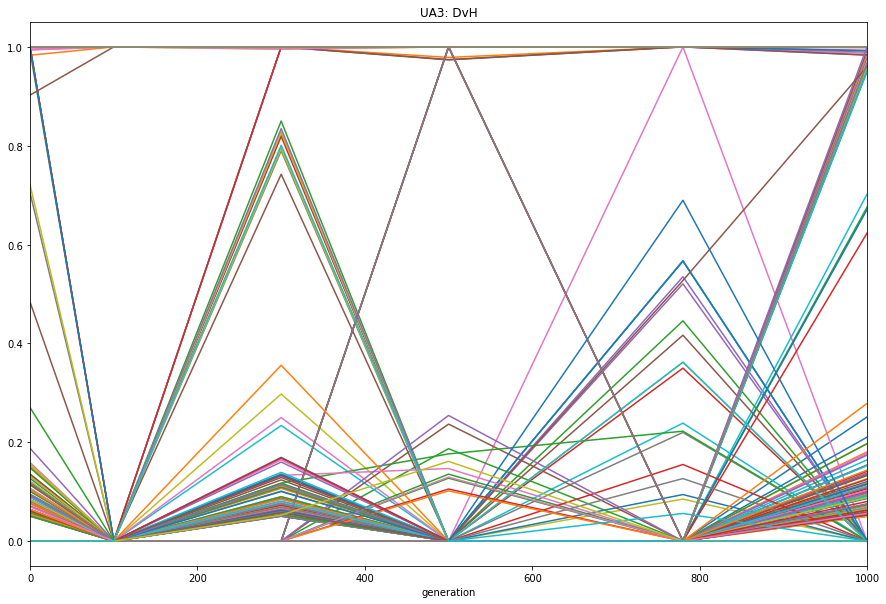

In [24]:
%matplotlib inline
ua3_reshaped['NC_002937'].plot(legend=False, title = 'UA3: DvH', figsize=(15,10))
#plt.savefig('d2m1_ua3_dvh.png')

In [102]:
#DvH mutation types
set(ua3[ua3['genome_id'] == 'NC_002937']['entry_type'].tolist())

{'DEL', 'INS', 'MOB', 'SNP', 'SUB'}

In [130]:
#DvH SNP only
ua3[(ua3['genome_id'] == 'NC_002937') & (ua3['entry_type'] == 'SNP')].pivot_table(index=['position', 'mutation_detail'],
                               columns='generation',
                               values='polymorphism_frequency').dropna(how='all').fillna(0).T

position,1000532,1000538,1010155,1048916,1135158,1188745,1188746,1198146,1375964,1375983,...,666321,708564,716874,885112,885241,885407,896746,896752,896758,968220
mutation_detail,G,G,T,A,C,T,G,A,A,T,...,C,T,A,T,A,A,G,T,T,T
generation,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.00000,0.088728,0.078753,0.057387,0.057185,0.000000,0.000000,0.000000,...,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
100,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
300,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.297619,0.000000,0.824374,...,0.000000,0.0,1.0,0.000000,0.139053,0.000000,0.16795,0.114295,0.128714,0.801072
500,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.0,1.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
780,0.000000,0.000000,0.34999,0.000000,0.000000,0.000000,0.000000,0.000000,0.520578,0.000000,...,0.527269,0.0,1.0,0.000000,0.000000,0.689693,0.00000,0.000000,0.000000,0.000000
1000,0.251218,0.180501,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.960216,0.0,1.0,0.966933,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


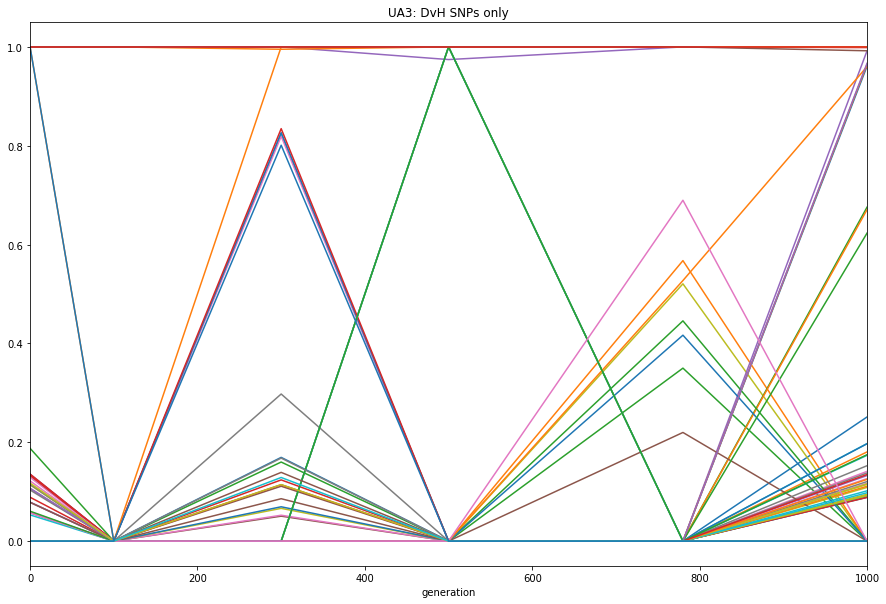

In [53]:
ua3[(ua3['genome_id'] == 'NC_002937') & (ua3['entry_type'] == 'SNP')].pivot_table(index=['position', 'mutation_detail'],
                               columns='generation',
                               values='polymorphism_frequency').dropna(how='all').fillna(0).T.plot(legend=False, figsize=(15,10), title='UA3: DvH SNPs only')

In [129]:
#DvH SUB only
ua3[(ua3['genome_id'] == 'NC_002937') & (ua3['entry_type'] == 'SUB')].pivot_table(index=['position', 'mutation_detail'],
                               columns='generation',
                               values='polymorphism_frequency').dropna(how='all').fillna(0).T

position,1110818,2514116,3064064,3138220,3403956,809173
mutation_detail,59,98,2,120,44,65
generation,,,,,,
0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
100,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
300,0.000000,0.000000,1.0,0.000000,0.113687,0.057786
500,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
780,0.085083,0.000000,1.0,0.000000,0.000000,0.000000
1000,0.000000,0.091802,1.0,0.059105,0.000000,0.000000


In [128]:
# DvH INS only
ua3[(ua3['genome_id'] == 'NC_002937') & (ua3['entry_type'] == 'INS')].pivot_table(index=['position', 'mutation_detail'],
                               columns='generation',
                               values='polymorphism_frequency').dropna(how='all').fillna(0).T

position          1144620 1313341   1347082   1897096   2083305    211389  \
mutation_detail         C       C         A         T         C         A   
generation                                                                  
0                0.991103     1.0  0.000000  1.000000  0.983164  1.000000   
100              0.000000     1.0  0.000000  0.000000  1.000000  1.000000   
300              1.000000     1.0  0.850009  1.000000  1.000000  1.000000   
500              1.000000     1.0  0.000000  1.000000  0.978731  1.000000   
780              1.000000     1.0  0.000000  1.000000  1.000000  1.000000   
1000             1.000000     1.0  0.000000  0.993025  1.000000  0.983232   

position           295152   2982788 3056212 3066926   3140594            \
mutation_detail         C         C       G     ACG         A         G   
generation                                                                
0                0.129944  0.483522     1.0     1.0  0.704306  0.720375   
100              0.000000  0.000000     1.0     1.0  0.000000  0.000000   
300              0.000000  0.742273     1.0     1.0  0.789726  0.794334   
500              0.000000  0.000000     1.0     1.0  0.000000  0.000000   
780              0.000000  0.000000     1.0     1.0  0.000000  0.000000   
1000             0.000000  0.000000     1.0     1.0  0.000000  0.000000   

position                    3276860   3455727 3457155   3506947    42867  
mutation_detail        GA         C         T     CGC         G        G  
generation                                                                
0                0.000000  0.000000  0.902522     1.0  0.083682  0.99579  
100              0.000000  0.000000  1.000000     1.0  0.000000  1.00000  
300              0.000000  0.000000  1.000000     1.0  0.000000  0.99607  
500              0.000000  0.000000  0.973701     1.0  0.000000  1.00000  
780              0.000000  0.000000  1.000000     1.0  0.000000  1.00000  
1000             0.950368  0.977789  0.983621     1.0  0.000000  1.00000

In [125]:
# DvH DEL only
ua3[(ua3['genome_id'] == 'NC_002937') & (ua3['entry_type'] == 'DEL')].pivot_table(index=['position', 'mutation_detail'],
                               columns='generation',
                               values='polymorphism_frequency').dropna(how='all').fillna(0).T

position,1000569,1070072,1106513,1108458,1119239,1130412,1159324,1186582,1191167,1198489,...,807594,807617,80835,828278,882512,896701,896719,913304,933092,963632
mutation_detail,75,71,54,48,3,39,105,1,1,2,...,69,69,27,36,1,45,45,57,1,86
generation,,,,,,,,,,,,,,,,,,,,,
0,0.102928,0.000000,0.000000,0.050439,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.061904,0.092414,0.000000,1.0,0.064115,0.270161,0.069367,0.000000,0.000000
100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
300,0.000000,0.050261,0.072368,0.000000,0.000000,0.051911,0.000000,0.000000,1.000000,0.000000,...,0.117061,0.000000,0.000000,0.000000,1.0,0.355818,0.000000,0.000000,0.000000,0.052547
500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.161354
780,0.000000,0.000000,0.000000,0.000000,0.238686,0.000000,0.000000,0.534881,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
1000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105752,0.000000,0.989132,0.959597,...,0.000000,0.000000,0.000000,0.056075,1.0,0.278667,0.000000,0.000000,0.966792,0.000000


In [139]:
# DvH MOB only
ua3[(ua3['genome_id'] == 'NC_002937') & (ua3['entry_type'] == 'MOB')].pivot_table(index=['position', 'mutation_detail'],
                               columns='generation',
                               values='polymorphism_frequency').fillna(0).T

position,629936
mutation_detail,ISD1
generation,
1000,1.0


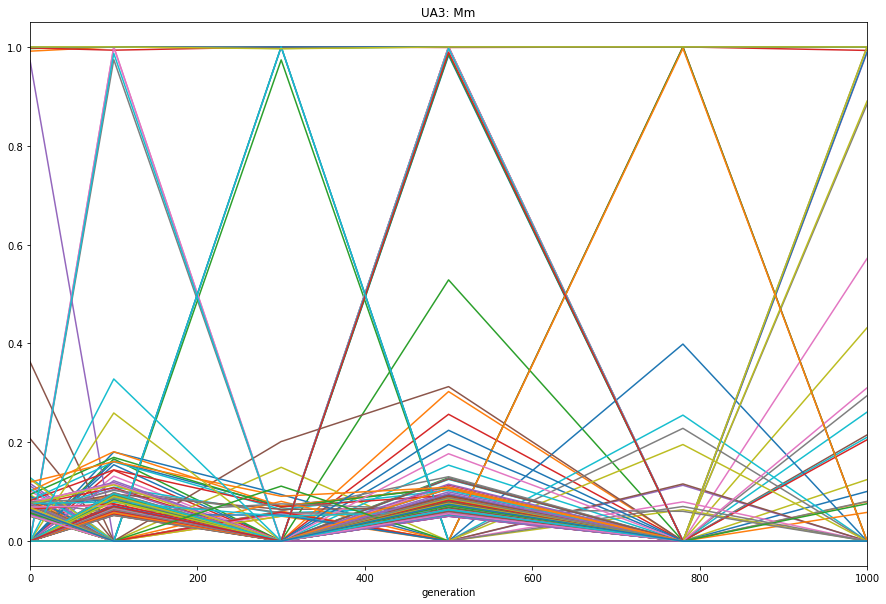

In [38]:
ua3_reshaped['NC_005791'].plot(legend=False, title = 'UA3: Mm', figsize=(15,10))
#plt.savefig('d2m1_ua3_mm.png')

In [116]:
#Mm mutation types
set(ua3[ua3['genome_id'] == 'NC_005791']['entry_type'].tolist())

{'DEL', 'INS', 'SNP', 'SUB'}

In [124]:
#Mm SNP only
ua3[(ua3['genome_id'] == 'NC_005791') & (ua3['entry_type'] == 'SNP')].pivot_table(index=['position', 'mutation_detail'],
                               columns='generation',
                               values='polymorphism_frequency').dropna(how='all').fillna(0).T

position,1031597,1031606,1031608,1031617,1034148,1034155,1034156,1126316,1126317,1126321,...,894463,894466,894470,982472,982486,982487,982490,982492,982497,982498
mutation_detail,G,A,G,A,C,G,T,T,T,A,...,T,C,T,C,G,A,T,T,C,C
generation,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.061548,0.062463,0.055106,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.060919,0.000000,0.051664,0.061823,0.067677,0.000000,0.063444
100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.154537,0.000000,0.166300,...,0.063565,0.081456,0.095812,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
500,0.128195,0.081159,0.064486,0.054386,0.000000,0.000000,0.000000,0.000000,0.302605,0.528572,...,0.000000,0.000000,0.062965,0.000000,0.060019,0.055309,0.087887,0.076435,0.063897,0.074533
780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [123]:
#Mm SUB only
ua3[(ua3['genome_id'] == 'NC_005791') & (ua3['entry_type'] == 'SUB')].pivot_table(index=['position', 'mutation_detail'],
                               columns='generation',
                               values='polymorphism_frequency').dropna(how='all').fillna(0).T

position,1378094,1512025,514956,693892
mutation_detail,42,61,65,69
generation,,,,
0,0.000000,0.058853,0.000000,0.106151
100,0.000000,0.000000,0.069573,0.000000
500,0.079767,0.000000,0.000000,0.000000


In [122]:
#Mm INS only
ua3[(ua3['genome_id'] == 'NC_005791') & (ua3['entry_type'] == 'INS')].pivot_table(index=['position', 'mutation_detail'],
                               columns='generation',
                               values='polymorphism_frequency').dropna(how='all').fillna(0).T

position,1153734,1298610,1469436,1469968,830665
mutation_detail,AT,C,GCT,GTCCGTGGTCTGGAAGTCCTTTTTCAAGGAAGTACATTGGACCTCCTGCCATTTCTCCGTTGTCATCGACAGTTCTGTATTTAATTGCAAGAACTGCTTCTGCAT,CTG
generation,,,,,
0,0.991394,0.000000,0.000000,0.000000,0.00000
100,1.000000,0.000000,1.000000,0.000000,0.00000
300,1.000000,0.973715,0.000000,0.000000,0.00000
500,1.000000,0.000000,0.997773,0.000000,0.22428
780,1.000000,0.000000,0.000000,0.000000,0.00000
1000,1.000000,0.000000,0.000000,0.058065,0.00000


In [121]:
#Mm DEL only
ua3[(ua3['genome_id'] == 'NC_005791') & (ua3['entry_type'] == 'DEL')].pivot_table(index=['position', 'mutation_detail'],
                               columns='generation',
                               values='polymorphism_frequency').dropna(how='all').fillna(0).T

position,1022458,1091498,113117,113133,1137521,1169797,1169824,1169828,1180973,1181000,...,765471,780831,780843,81931,841465,867588,918775,946124,946129,980778
mutation_detail,72,39,90,90,63,27,90,90,135,108,...,93,21,21,57,44,90,72,39,81,27
generation,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.093741,0.073386,0.068721,0.000000,0.088227,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.119279,0.000000,0.000000,0.000000,0.000000,0.000000
100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.143386,0.000000,0.000000,0.000000,...,0.058581,0.00000,0.094767,0.000000,0.160946,0.328063,0.071429,0.000000,0.000000,0.070265
300,0.050439,0.056714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.090735,0.000000,0.000000,0.000000,0.111229,0.000000
500,0.000000,0.069763,0.084127,0.000000,0.077577,0.000000,0.112857,0.000000,0.000000,0.000000,...,0.086819,0.08785,0.000000,0.051654,0.108871,0.000000,0.000000,0.106042,0.000000,0.000000
780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124425,0.261078,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


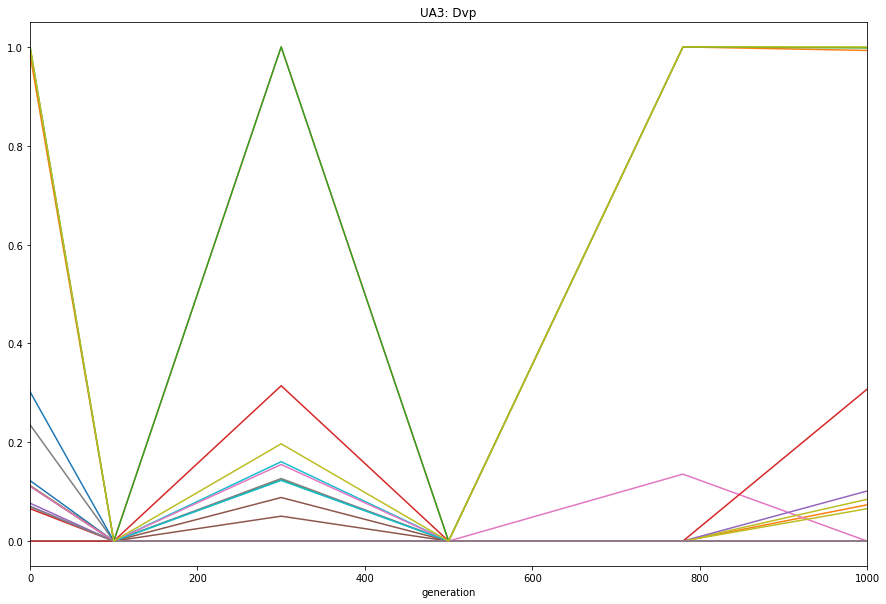

In [47]:
ua3_reshaped['NC_005863'].plot(legend=False, title = 'UA3: Dvp', figsize=(15,10))
plt.savefig('d2m1_ua3_Dvp.png')

In [48]:
#Dvp mutation types
set(ua3[ua3['genome_id'] == 'NC_005863']['entry_type'].tolist())

{'DEL', 'INS', 'SNP'}

In [62]:
ua3_dvh = ua3_reshaped['NC_002937']
ua3_mm = ua3_reshaped['NC_005791']
ua3_dvp = ua3_reshaped['NC_005863']
ua3_dvh

position,1000532,1000538,1000569,1010155,1048916,1070072,1106513,1108458,1110818,1119239,...,885407,896701,896719,896746,896752,896758,913304,933092,963632,968220
entry_type,SNP,SNP,DEL,SNP,SNP,DEL,DEL,DEL,SUB,DEL,...,SNP,DEL,DEL,SNP,SNP,SNP,DEL,DEL,DEL,SNP
mutation_detail,G,G,75,T,A,71,54,48,59,3,...,A,45,45,G,T,T,57,1,86,T
generation,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.102928,0.00000,0.088728,0.000000,0.000000,0.050439,0.000000,0.000000,...,0.000000,0.064115,0.270161,0.00000,0.000000,0.000000,0.069367,0.000000,0.000000,0.000000
100,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
300,0.000000,0.000000,0.000000,0.00000,0.000000,0.050261,0.072368,0.000000,0.000000,0.000000,...,0.000000,0.355818,0.000000,0.16795,0.114295,0.128714,0.000000,0.000000,0.052547,0.801072
500,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.161354,0.000000
780,0.000000,0.000000,0.000000,0.34999,0.000000,0.000000,0.000000,0.000000,0.085083,0.238686,...,0.689693,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1000,0.251218,0.180501,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.278667,0.000000,0.00000,0.000000,0.000000,0.000000,0.966792,0.000000,0.000000


In [41]:
def plot_multiples(df, nrows, ncols, start_index=0, line_color='red'):
    fig, axes = plt.subplots(nrows, ncols, sharex = True, sharey = True, figsize=(15,10))
    count = 0
    while count < (nrows*ncols):
        for axrow in range(nrows):
            for axcol in range(ncols):
                df[df.columns[start_index + count]].plot(ax = axes[axrow][axcol], color=line_color)
                count += 1

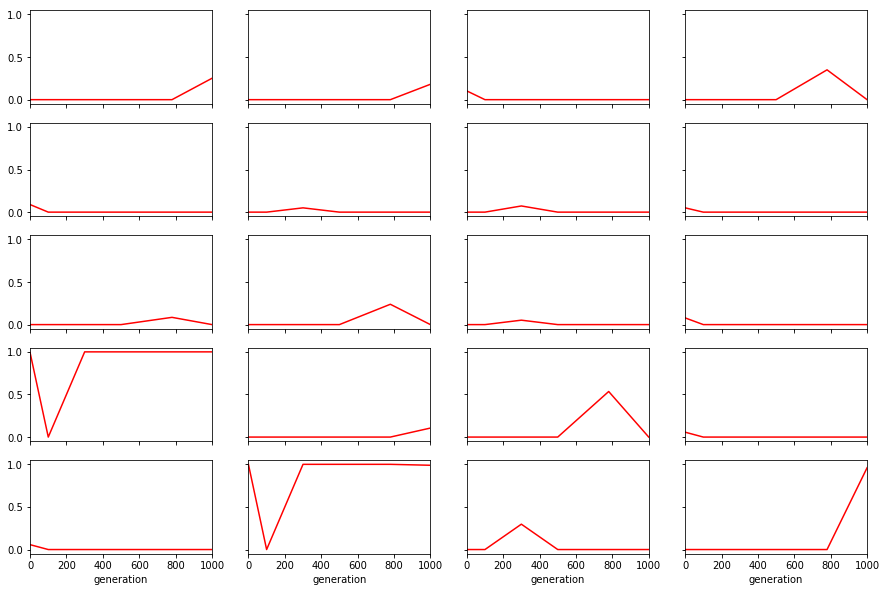

In [42]:
plot_multiples(ua3_dvh, 5, 4)
plt.savefig('ua3_dvh_20.png')

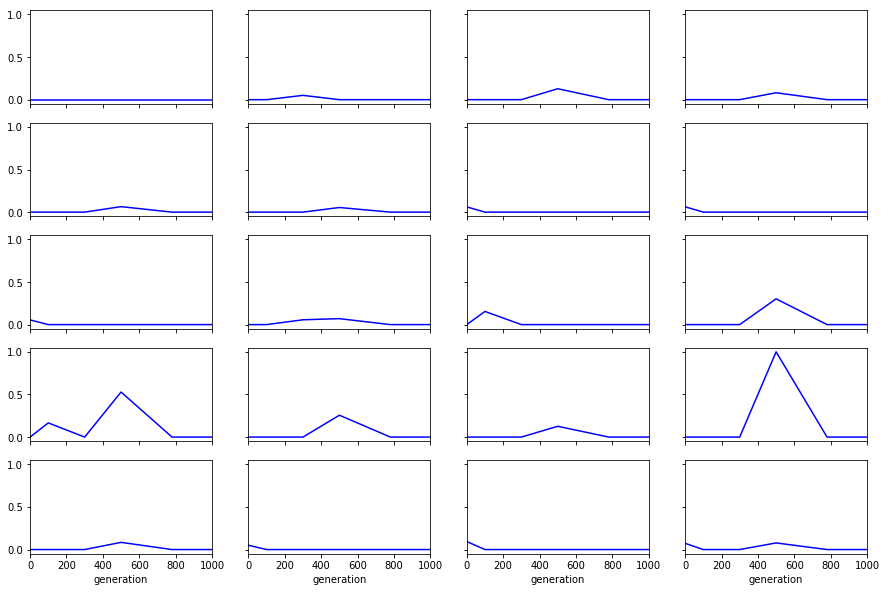

In [43]:
plot_multiples(ua3_mm, 5, 4, 0, 'blue')
plt.savefig('ua3_mm_20.png')

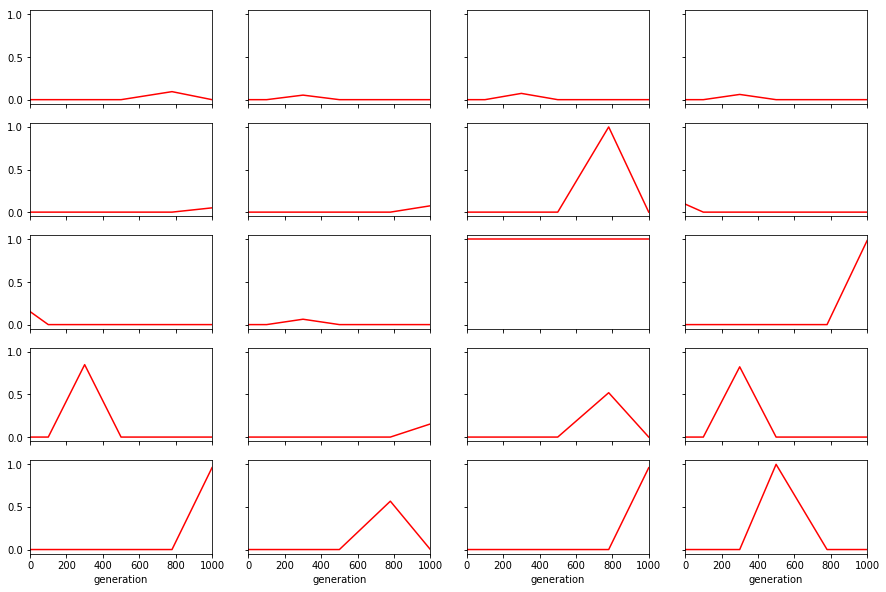

In [44]:
plot_multiples(ua3_dvh, 5, 4, 20)
plt.savefig('ua3_dvh_40.png')

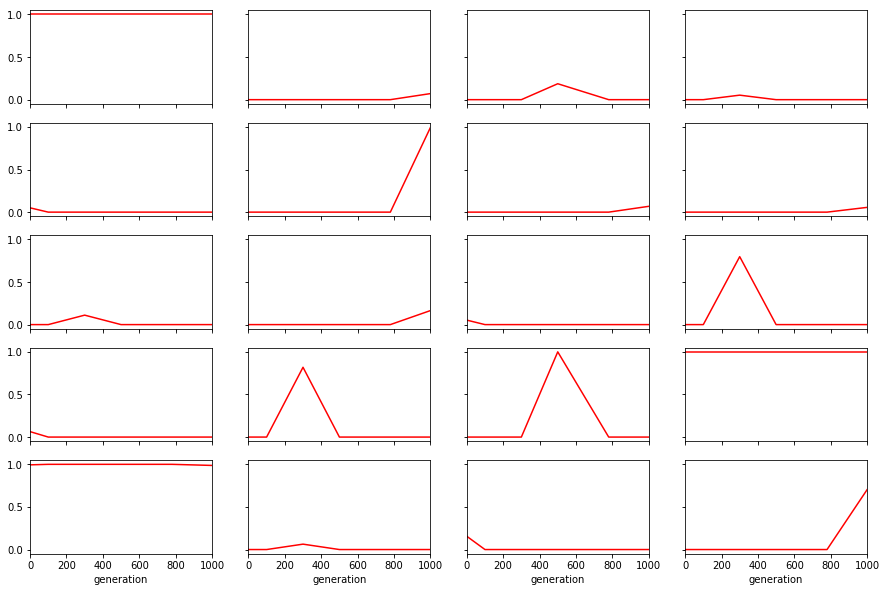

In [45]:
plot_multiples(ua3_dvh, 5, 4, 40)
plt.savefig('ua3_dvh_60.png')

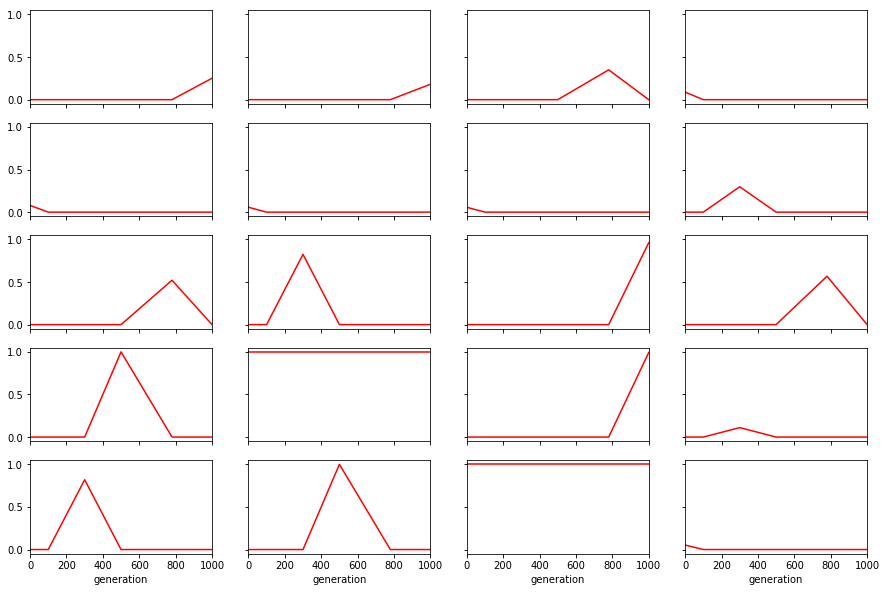

In [58]:
ua3_dvh_snp = ua3[(ua3['genome_id'] == 'NC_002937') & (ua3['entry_type'] == 'SNP')].pivot_table(index=['position', 'mutation_detail'],
                               columns='generation',
                               values='polymorphism_frequency').dropna(how='all').fillna(0).T
plot_multiples(ua3_dvh_snp, 5, 4)

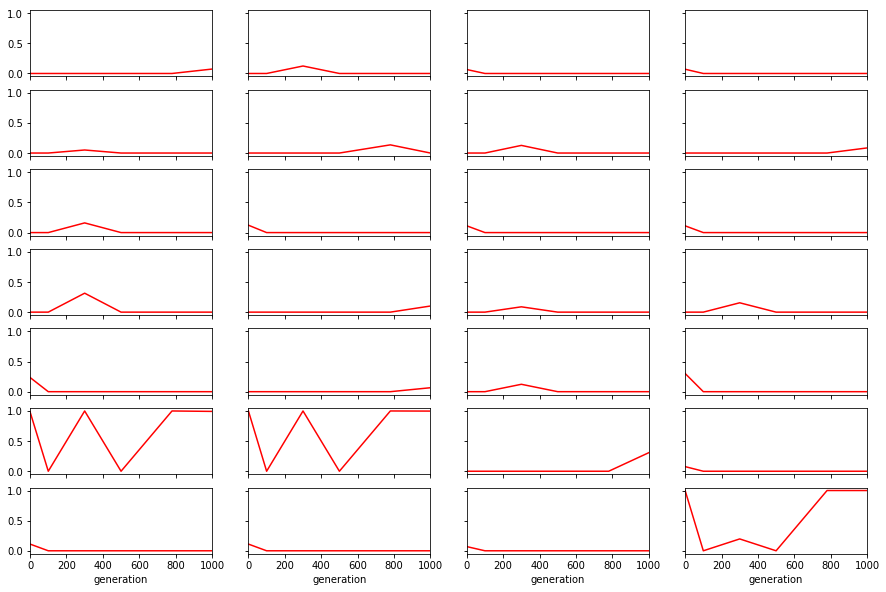

In [52]:
plot_multiples(ua3_dvp, 7, 4, 1)